# Hierarchical logistic growth model

In [1]:
import arviz as az
import chi
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import pints
import seaborn as sns
sns.set_theme()

The data-generating model is a hierarchical logistic growth model governed
by

$$
    p(y, \psi | \theta , t) = p(y | \psi , t)\, p(\psi | \theta),
$$

where $\psi = (y_0, \lambda, k, \sigma)$ and
$\theta = (\mu_{y_0}, \mu_{\lambda}, \mu_{k}, \sigma_{y_0}, \sigma_{\lambda}, \sigma_{k}, \theta_{\sigma})$.
The measurements of individuals are governed by a distribution defined by the
mechanistic model-error model pair

$$
    p(y | \psi , t) =
        \mathrm{LN}\left( y | \log \bar{y}(\psi, t), \sigma \right)
    \quad \text{with}\quad
    \bar{y}(\psi, t) = \frac{y_0k}{y_0 + (k - y_0)\mathrm{e}^{-\lambda t}}
$$

and the inter-individual variability is governed by the population model

$$
    p(\psi | \theta) =
        \mathrm{LN}(y_0 | \mu_{y_0}, \sigma_{y_0})\,
        \mathrm{LN}(\lambda | \mu_{\lambda}, \sigma_{\lambda})\,
        \mathcal{N}(k | \mu_{k}, \sigma ^2_{k})\,
        \delta (\sigma - \theta_{\sigma}).
$$

## Define data-generating model

In [2]:
class ToyLogisticGrowthModel(chi.MechanisticModel):
    """
    A toy logistic growth model.
    """
    def __init__(self):
        super(ToyLogisticGrowthModel, self).__init__()

        self._has_sensitivities = False

    def enable_sensitivities(self, enabled, parameter_names=None):
        r"""
        Enables the computation of the model output sensitivities to the model
        parameters if set to ``True``.

        The sensitivities of the model outputs are defined as the partial
        derviatives of the ouputs :math:`\bar{y}` with respect to the model
        parameters :math:`\psi`

        .. math:
            \frac{\del \bar{y}}{\del \psi}.

        :param enabled: A boolean flag which enables (``True``) / disables
            (``False``) the computation of sensitivities.
        :type enabled: bool
        """
        self._has_sensitivities = bool(enabled)

    def has_sensitivities(self):
        """
        Returns a boolean indicating whether sensitivities have been enabled.
        """
        return self._has_sensitivities

    def n_outputs(self):
        """
        Returns the number of output dimensions.

        By default this is the number of states.
        """
        return 1

    def n_parameters(self):
        """
        Returns the number of parameters in the model.

        Parameters of the model are initial state values and structural
        parameter values.
        """
        return 3

    def outputs(self):
        """
        Returns the output names of the model.
        """
        return ['Count']

    def parameters(self):
        """
        Returns the parameter names of the model.
        """
        return ['Initial count', 'Growth rate', 'Capacity']

    def simulate(self, parameters, times):
        """
        Returns the numerical solution of the model outputs (and optionally
        the sensitivites) for the specified parameters and times.

        The model outputs are returned as a 2 dimensional NumPy array of shape
        ``(n_outputs, n_times)``. If sensitivities are enabled, a tuple is
        returned with the NumPy array of the model outputs and a NumPy array of
        the sensitivities of shape ``(n_times, n_outputs, n_parameters)``.

        :param parameters: An array-like object with values for the model
            parameters.
        :type parameters: list, numpy.ndarray
        :param times: An array-like object with time points at which the output
            values are returned.
        :type times: list, numpy.ndarray

        :rtype: np.ndarray of shape (n_outputs, n_times) or
            (n_times, n_outputs, n_parameters)
        """
        y0, growth_rate, capacity = parameters
        times = np.asarray(times)

        # Solve model
        y = \
            capacity * y0 \
            / (y0 + (capacity - y0) * np.exp(-growth_rate * times))

        if not self._has_sensitivities:
            return y[np.newaxis, :]

        sensitivities = np.empty(shape=(len(times), 1, 3))
        sensitivities[:, 0, 0] = \
            capacity \
            / (y0 + (capacity - y0) * np.exp(-growth_rate * times)) \
            - (capacity * y0) \
            / (y0 + (capacity - y0) * np.exp(-growth_rate * times)) ** 2 \
            * (1 - np.exp(-growth_rate * times))
        sensitivities[:, 0, 1] = \
            (capacity - y0) * y * times * np.exp(-growth_rate * times) \
            / (y0 + (capacity - y0) * np.exp(-growth_rate * times))
        sensitivities[:, 0, 2] = \
            y0 / (y0 + (capacity - y0) * np.exp(-growth_rate * times))\
             - (capacity * y0) * np.exp(-growth_rate * times) \
            / (y0 + (capacity - y0) * np.exp(-growth_rate * times)) ** 2

        return y[np.newaxis, :], sensitivities

# Data-generating parameters
population_parameters = [
    1.8,   # Log mean initial condition
    2.3,   # Log mean exponential growth
    0.4,   # Log std. initial condition
    0.5,   # Log std. exponential growth
    110,   # Mean capacity
    5,     # Std. capacity
    0.08]  # Sigma

## 0. Distributional shape of data-generating process over time

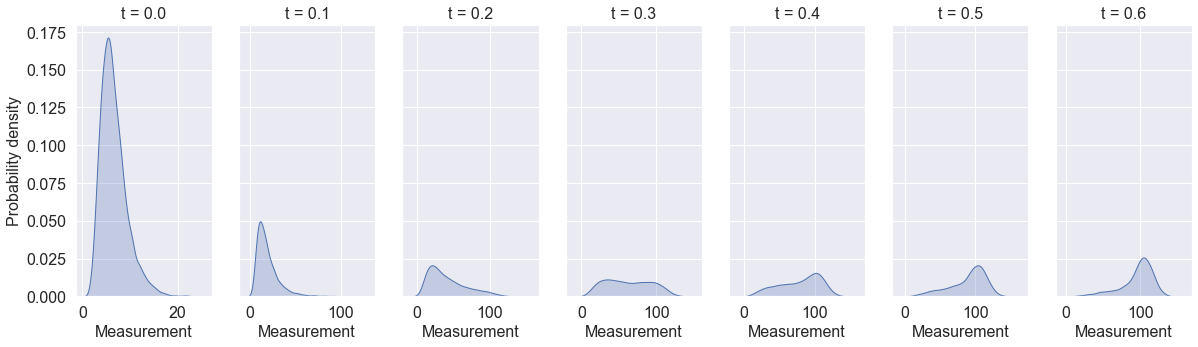

In [3]:
# Define data-generating model
mechanistic_model = ToyLogisticGrowthModel()
error_model = chi.LogNormalErrorModel()
population_model = chi.ComposedPopulationModel([
    chi.LogNormalModel(n_dim=2, dim_names=['Initial count', 'Growth rate']),
    chi.GaussianModel(dim_names=['Capacity']),
    chi.PooledModel(dim_names=['Sigma'])])
predictive_model = chi.PredictiveModel(mechanistic_model, error_model)
predictive_model = chi.PopulationPredictiveModel(
    predictive_model, population_model)

# Simulate measurements
seed = 2
n_ids = 5000
times = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
measurements = predictive_model.sample(
    population_parameters, times, n_samples=n_ids, seed=seed, return_df=False)

# Visualise distributions over time
fontsize = '16'
fig, axes = plt.subplots(1, len(times), figsize=(20, 5), sharey='row')
axes[0].set_ylabel('Probability density', fontsize=fontsize)
for tid, time in enumerate(times):
    # Add title and x-label to subfigure
    axes[tid].set_title('t = %.1f' % time, fontsize=fontsize)
    axes[tid].set_xlabel('Measurement', fontsize=fontsize)
    axes[tid].tick_params(labelsize=fontsize)

    # Plot KDE plot
    sns.kdeplot(
        x=measurements[0, tid], fill=True, linewidth=1, ax=axes[tid],
        legend=False)

plt.show()

## 1. 100 Individuals (non-snapshot data)

In [4]:
# Define data-generating model
predictive_model = chi.PredictiveModel(mechanistic_model, error_model)
predictive_model = chi.PopulationPredictiveModel(
    predictive_model, population_model)

# Simulate measurements
seed = 2
n_ids = 100
times = np.linspace(0, 0.6)
measurements = predictive_model.sample(
    population_parameters, times, n_samples=n_ids, seed=seed, return_df=False)

# Swap axes for later convenience
measurements = np.moveaxis(
    measurements, source=(0, 1, 2), destination=(1, 2, 0))

fig = go.Figure()
for idx in range(n_ids):
    fig.add_trace(go.Scatter(
        x=times,
        y=measurements[idx, 0],
        mode='markers+lines',
        name='ID %d' % idx
    ))
fig.update_layout(
    template='plotly_white',
    xaxis_title='Time',
    yaxis_title='Measurement'
)
fig.show()

### Population filter inference

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     14     0.136    5        0:00.1
1     15     0.25     1        0:00.1
2     26     0.068    6        0:00.2
3     1049   0.497    512      0:07.1
20    13382  0.756    686      1:22.1
40    28243  0.768428 708      2:51.2
60    42170  0.765    664      4:20.7
80    55371  0.757    629      5:49.6
100   67802  0.746    592      7:08.4
120   69652  0.712    89       7:19.7
140   71457  0.766    86       7:30.8
160   72790  0.732    64       7:38.7
180   74506  0.745    82       7:48.7
200   76003  0.767    72       7:58.2
220   77176  0.739    56       8:05.7
240   78404  0.758    59       8:13.4
260   79770  0.713957 65       8:22.2
280   81111  0.764899 64       8:31.5
300   82231  0.749606 54       8:39.3
320   83395  0.758    56       8:47.9
340   84770  0.746528 66       8:56.0
360   85974  0.759    58       9:03.6
380   87182  0.775    58       9:10.8
400   88370  0.754

/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/arviz/plots/traceplot.py:210: UserWarning:

rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (59), generating only 20 plots



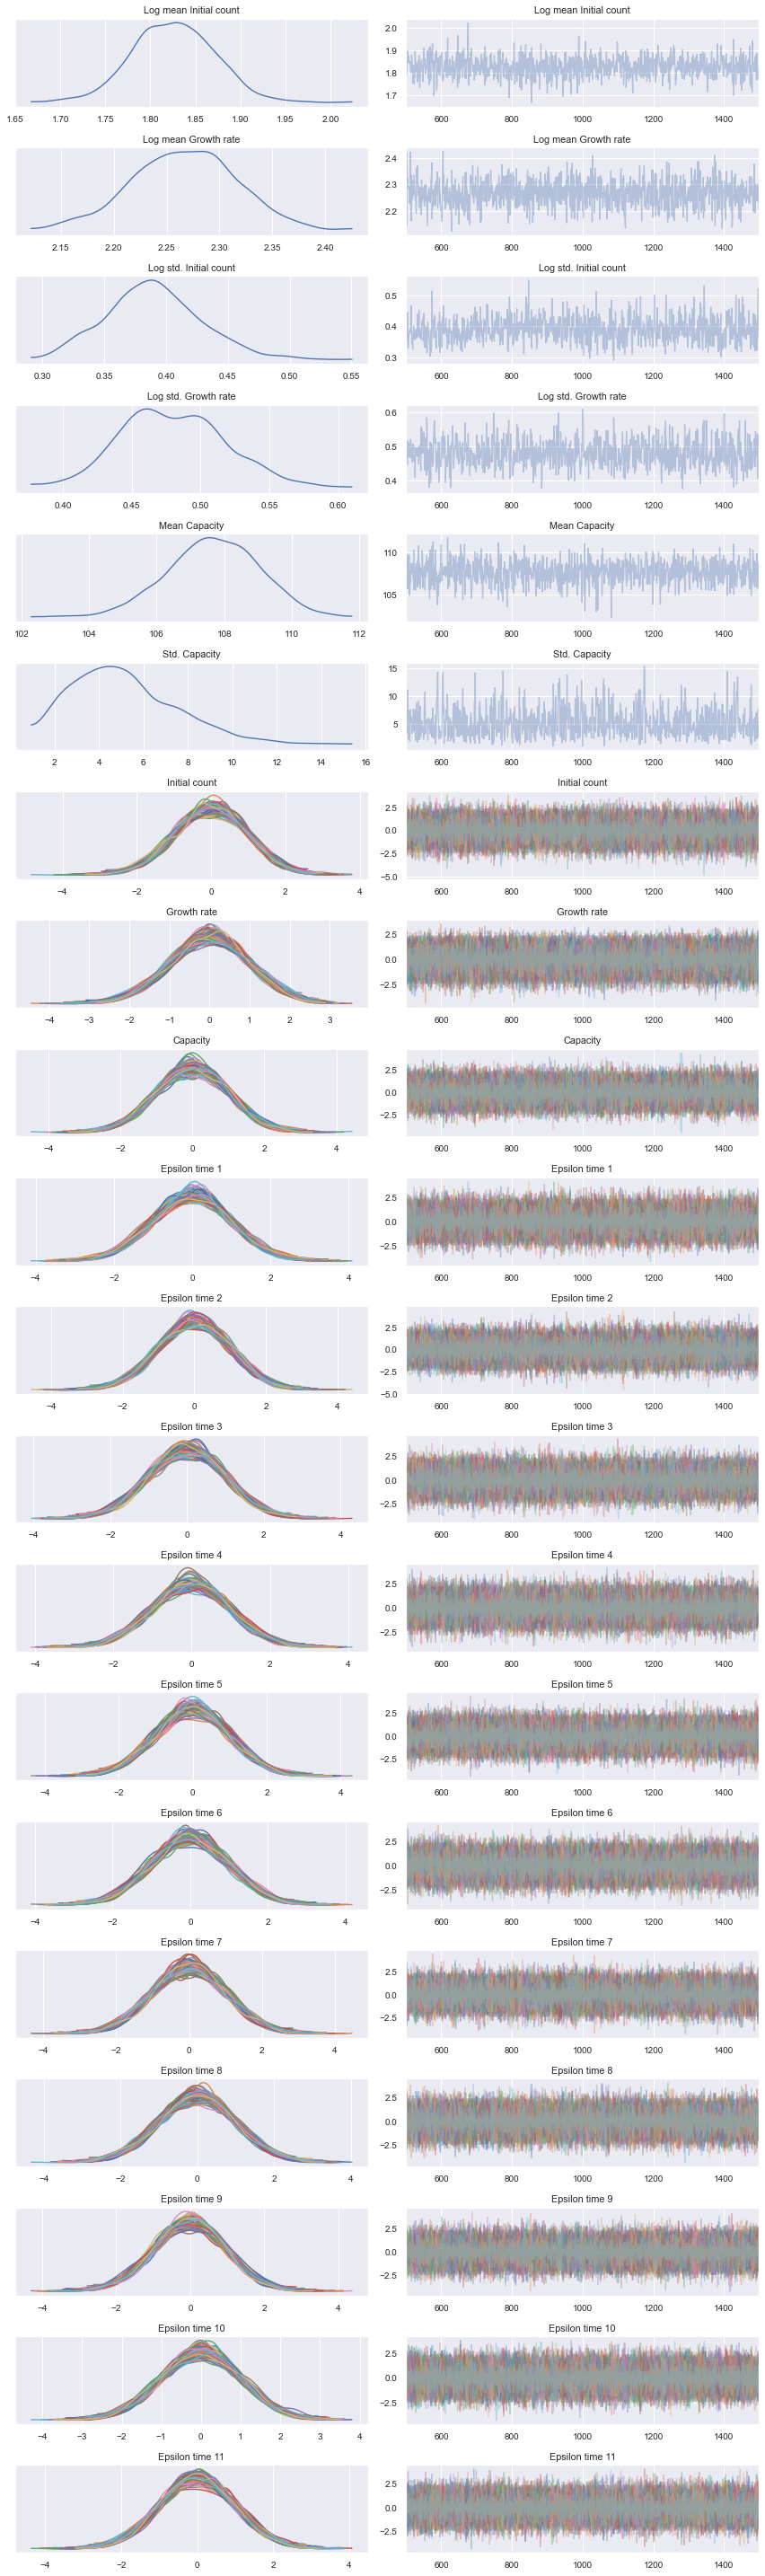

In [27]:
# Define population filter log-posterior
# mask = times < 0.2
# population_filter = chi.ComposedPopulationFilter([
#     chi.LogNormalFilter(measurements[:, :, mask]),
#     chi.GaussianKDEFilter(measurements[:, :, ~mask])])
population_filter = chi.GaussianFilter(measurements)
population_model = chi.ComposedPopulationModel([
    chi.LogNormalModel(
        n_dim=2, dim_names=['Initial count', 'Growth rate'], centered=False),
    chi.GaussianModel(dim_names=['Capacity'], centered=False)])
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(1, 3),        # Log mean initial condition
    pints.GaussianLogPrior(3, 3),        # Log mean exponential growth
    pints.LogNormalLogPrior(-0.1, 0.5),  # Log std. initial condition
    pints.LogNormalLogPrior(-0.1, 0.5),  # Log std. exponential growth
    pints.GaussianLogPrior(100, 10),     # Mean capacity
    pints.LogNormalLogPrior(1.5, 0.5))   # Std. capacity
log_posterior = chi.PopulationFilterLogPosterior(
    population_filter, times, mechanistic_model, population_model, log_prior,
    sigma=population_parameters[-1], error_on_log_scale=True)

# Run inference
seed = 2
controller = chi.SamplingController(log_posterior, seed=seed)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
posterior_samples_filter = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning = 1
az.plot_trace(
    posterior_samples_filter.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

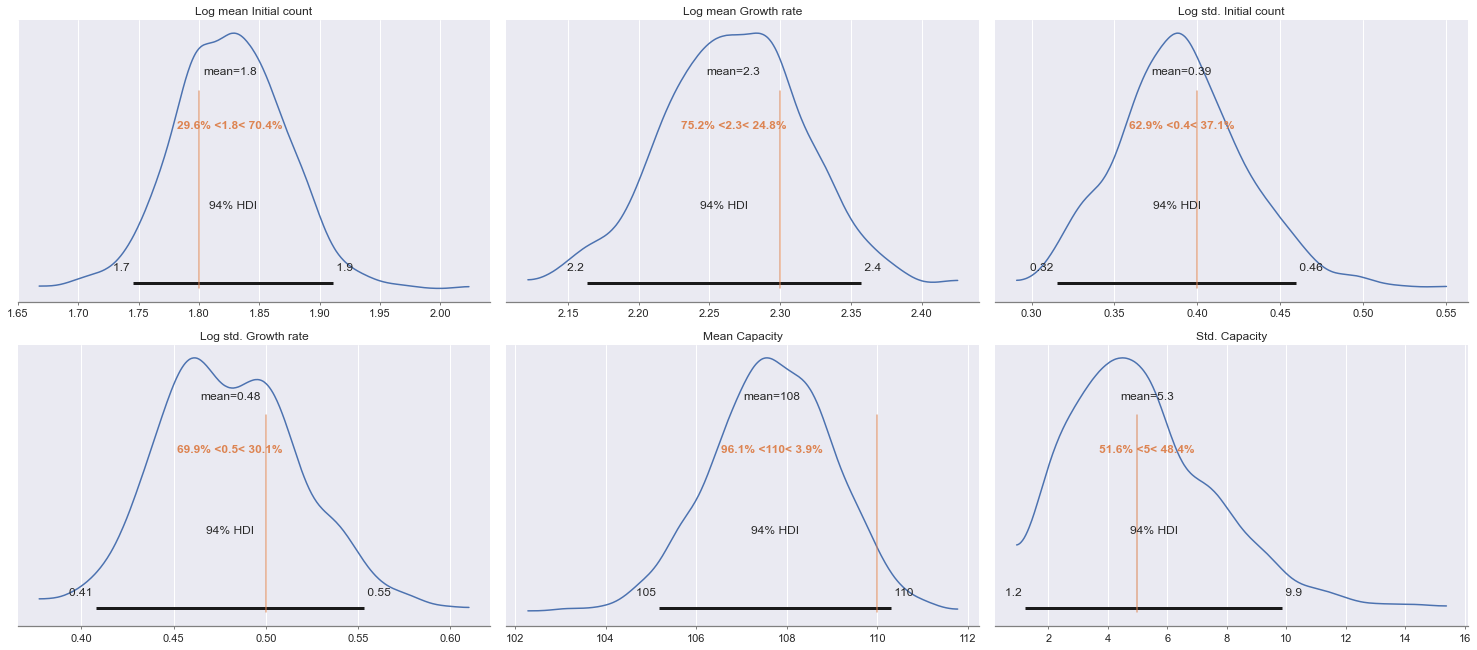

In [28]:
warmup = 500
thinning = 1
az.plot_posterior(
    posterior_samples_filter.sel(draw=slice(warmup, n_iterations, thinning)),
    var_names=[
        'Log mean Initial count',
        'Log mean Growth rate',
        'Log std. Initial count',
        'Log std. Growth rate',
        'Mean Capacity',
        'Std. Capacity'],
    ref_val=population_parameters[:-1])
plt.tight_layout()

### Results

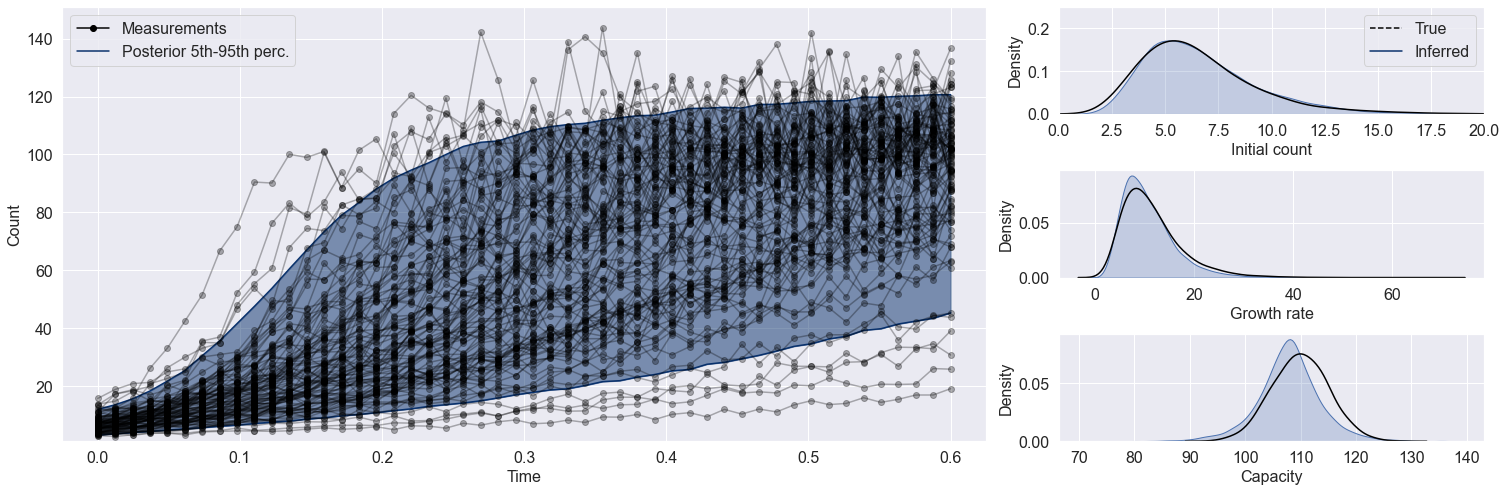

In [36]:
# Set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(1, 3, (1, 2))
ax2 = fig.add_subplot(3, 3, 3)
ax3 = fig.add_subplot(3, 3, 6)
ax4 = fig.add_subplot(3, 3, 9)
axes = [ax2, ax3, ax4]

# Define population model (central parametrisation)
population_model = chi.ComposedPopulationModel([
    chi.LogNormalModel(n_dim=2, dim_names=['Initial count', 'Growth rate']),
    chi.GaussianModel(dim_names=['Capacity'])])

# Plot population filter inference results (parameter space)
seed = np.random.default_rng(3)
n_samples = 5000
parameters =  posterior_samples_filter.sel(draw=slice(warmup, n_iterations))
parameters = np.vstack([
    parameters['Log mean Initial count'].values.flatten(),
    parameters['Log mean Growth rate'].values.flatten(),
    parameters['Log std. Initial count'].values.flatten(),
    parameters['Log std. Growth rate'].values.flatten(),
    parameters['Mean Capacity'].values.flatten(),
    parameters['Std. Capacity'].values.flatten()]).T
parameters = parameters[
    np.random.choice(np.arange(len(parameters)), size=n_samples, replace=True)]
samples = np.empty(shape=(n_samples, 3))
for ids, params in enumerate(parameters):
    samples[ids, :] = population_model.sample(params, seed=seed)[0]
for idp, _ in enumerate(['Initial count', 'Growth rate', 'Capacity']):
    sns.kdeplot(
        x=samples[:, idp], fill=True, bw_adjust=1, ax=axes[idp])

# Plot population filter inference results (measurement space)
times = np.linspace(0, 0.6)
n_times = len(times)
predictive_model = chi.PredictiveModel(mechanistic_model, error_model)
simulated_measurements = np.empty(shape=(n_samples, n_times))
parameters = np.empty(shape=(n_samples, 4))
parameters[:, :3] = samples
parameters[:, 3] = population_parameters[-1]
for ids, sample in enumerate(parameters):
    simulated_measurements[ids, :] = predictive_model.sample(
        parameters=sample, times=times, seed=seed, return_df=False)[0, :, 0]
fifth_percentile = np.percentile(simulated_measurements, q=5, axis=0)
ninetyfifth_percentile = np.percentile(simulated_measurements, q=95, axis=0)
ax1.plot(
    times, fifth_percentile, color=plt.get_cmap('Blues_r')(0))
ax1.plot(
    times, ninetyfifth_percentile, color=plt.get_cmap('Blues_r')(0))
ax1.fill_between(
    times, fifth_percentile, ninetyfifth_percentile,
    color=plt.get_cmap('Blues_r')(0), alpha=0.5)

# Plot data-generating distribution as reference to parameter space
samples = population_model.sample(population_parameters[:-1], n_samples, seed)
for idp, _ in enumerate(['Initial count', 'Growth rate', 'Capacity']):
    sns.kdeplot(
        x=samples[:, idp], fill=False, bw_adjust=1.5, color='black',
        ax=axes[idp])

# Plot measurement used for the inference as reference
for idm, meas in enumerate(measurements):
    ax1.plot(
        times, meas[0], color='black', marker='o', linestyle='solid',
        alpha=0.3)

# Legend, ranges axes labels
fontsize = 16
ax1.set_xlabel('Time', fontsize=fontsize)
ax1.set_ylabel('Count', fontsize=fontsize)
ax1.tick_params(labelsize=fontsize)
ax1.plot(
    [1000, 1001], [1000, 1001], color='black', linestyle='solid', marker='o',
    label='Measurements')
ax1.plot(
    [1000, 1001], [1000, 1001], color=plt.get_cmap('Blues_r')(0),
    linestyle='solid', label='Posterior 5th-95th perc.')
ax1.set_xlim([-0.025, 0.625])
ax1.set_ylim([1, 151])
ax2.plot(
    [100, 101], [100, 101], color='black', linestyle='--', label='True')
ax2.plot(
    [100, 101], [100, 101], color=plt.get_cmap('Blues_r')(0),label='Inferred')
ax2.set_xlim([0, 20])
ax2.set_ylim([0, 0.25])
ax2.set_xlabel('Initial count', fontsize=fontsize)
ax2.set_ylabel('Density', fontsize=fontsize)
ax2.tick_params(labelsize=fontsize)
ax3.set_xlabel('Growth rate', fontsize=fontsize)
ax3.set_ylabel('Density', fontsize=fontsize)
ax3.tick_params(labelsize=fontsize)
ax4.set_xlabel('Capacity', fontsize=fontsize)
ax4.set_ylabel('Density', fontsize=fontsize)
ax4.tick_params(labelsize=fontsize)
ax1.legend(fontsize=fontsize)
ax2.legend(fontsize=fontsize)
plt.tight_layout()
plt.show()

## 1. 5000 Individuals (snapshot data)

In [37]:
# Define data-generating model
mechanistic_model = ToyLogisticGrowthModel()
error_model = chi.GaussianErrorModel()
population_model = chi.ComposedPopulationModel([
    chi.LogNormalModel(n_dim=2, dim_names=['Initial count', 'Growth rate']),
    chi.GaussianModel(dim_names=['Capacity']),
    chi.PooledModel(dim_names=['Sigma'])])
predictive_model = chi.PredictiveModel(mechanistic_model, error_model)
predictive_model = chi.PopulationPredictiveModel(
    predictive_model, population_model)

# Simulate measurements
seed = 2
n_ids = 5000
times = np.linspace(0, 0.6)
dense_measurements = predictive_model.sample(
    population_parameters, times, n_samples=n_ids, seed=seed, return_df=False)

# Keep only one measurement per individual (100 measurements per time point)
n_ids = 100
n_times = len(times)
n_observables = 1
measurements = np.empty(shape=(n_ids, n_observables, n_times))
for idt in range(n_times):
    start_ids = idt * n_ids
    end_ids = (idt + 1) * n_ids
    measurements[:, 0, idt] = dense_measurements[0, idt, start_ids:end_ids]

# Visualise measurements
fig = go.Figure()
for idt in range(n_times):
    for idx in range(n_ids):
        fig.add_trace(go.Scatter(
            x=[times[idt]],
            y=[measurements[idx, 0, idt]],
            mode='markers+lines',
            name='ID %d' % (idt + (n_times * idx))
        ))
fig.update_layout(
    template='plotly_white',
    xaxis_title='Time',
    yaxis_title='Measurement'
)
fig.show()

### Population filter inference

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     13     0.5      4        0:00.1
1     14     0.25     1        0:00.1
2     15     0.25     1        0:00.1


ipykernel_launcher:89: RuntimeWarning:

divide by zero encountered in true_divide

ipykernel_launcher:97: RuntimeWarning:

divide by zero encountered in true_divide

ipykernel_launcher:100: RuntimeWarning:

divide by zero encountered in true_divide

ipykernel_launcher:100: RuntimeWarning:

invalid value encountered in multiply

ipykernel_launcher:103: RuntimeWarning:

invalid value encountered in multiply

ipykernel_launcher:105: RuntimeWarning:

divide by zero encountered in true_divide

ipykernel_launcher:107: RuntimeWarning:

divide by zero encountered in true_divide

ipykernel_launcher:107: RuntimeWarning:

invalid value encountered in subtract

ipykernel_launcher:100: RuntimeWarning:

overflow encountered in square

ipykernel_launcher:107: RuntimeWarning:

overflow encountered in square

/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/numpy/core/_methods.py:230: RuntimeWarning:

invalid value encountered in subtract

/Users/david/Workspace/

3     232    0.406    109      0:01.5
20    10979  0.744    597      1:18.2
40    25480  0.764    691      2:52.7
60    39151  0.771    651      4:18.1
80    51642  0.767448 595      5:35.4
100   61027  0.756    447      6:32.5
120   62694  0.709    80       6:43.1
140   64090  0.732    67       6:51.6
160   65521  0.749    68       7:00.3
180   66856  0.753    64       7:09.0
200   68385  0.745    73       7:18.8
220   69453  0.765    51       7:26.2
240   70803  0.763    65       7:34.3
260   72013  0.698    58       7:41.3
280   73357  0.761071 64       7:49.7
300   74562  0.755    58       7:56.7
320   75670  0.764    53       8:03.1
340   76799  0.751    54       8:10.1
360   77954  0.746    55       8:16.8
380   79086  0.763    54       8:23.5
400   80195  0.75     53       8:31.1
420   81144  0.768    46       8:36.6
440   82084  0.764    45       8:42.1
460   83143  0.702726 51       8:48.7
480   84583  0.771    69       8:57.0
500   85850  0.741    61       9:04.6
520   87110 

/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/arviz/plots/traceplot.py:210: UserWarning:

rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (59), generating only 20 plots



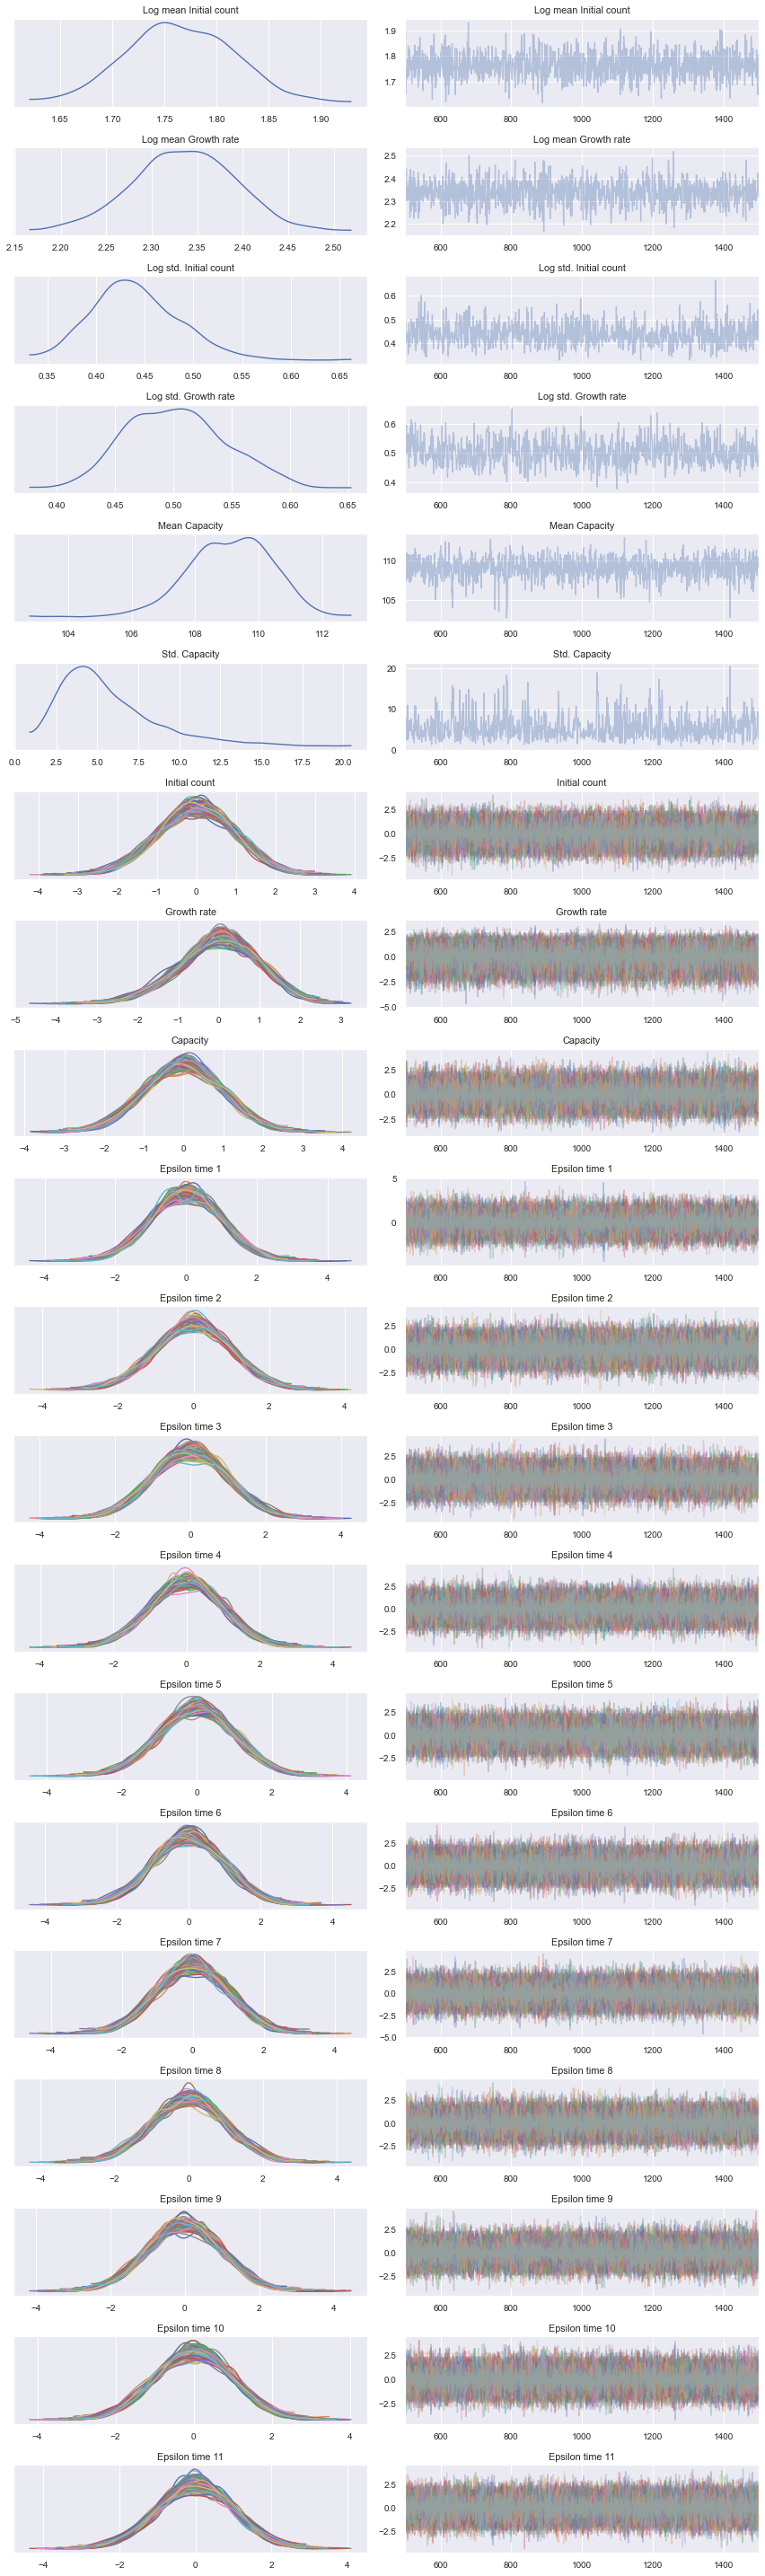

In [38]:
# Define population filter log-posterior
population_filter = chi.GaussianFilter(measurements)
population_model = chi.ComposedPopulationModel([
    chi.LogNormalModel(
        n_dim=2, dim_names=['Initial count', 'Growth rate'], centered=False),
    chi.GaussianModel(dim_names=['Capacity'], centered=False)])
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(1, 3),        # Log mean initial condition
    pints.GaussianLogPrior(3, 3),        # Log mean exponential growth
    pints.LogNormalLogPrior(-0.1, 0.5),  # Log std. initial condition
    pints.LogNormalLogPrior(-0.1, 0.5),  # Log std. exponential growth
    pints.GaussianLogPrior(100, 10),     # Mean capacity
    pints.LogNormalLogPrior(1.5, 0.5))   # Std. capacity
log_posterior = chi.PopulationFilterLogPosterior(
    population_filter, times, mechanistic_model, population_model, log_prior,
    sigma=population_parameters[-1])

# Run inference
seed = 2
controller = chi.SamplingController(log_posterior, seed=seed)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
posterior_samples_filter = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning = 1
az.plot_trace(
    posterior_samples_filter.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

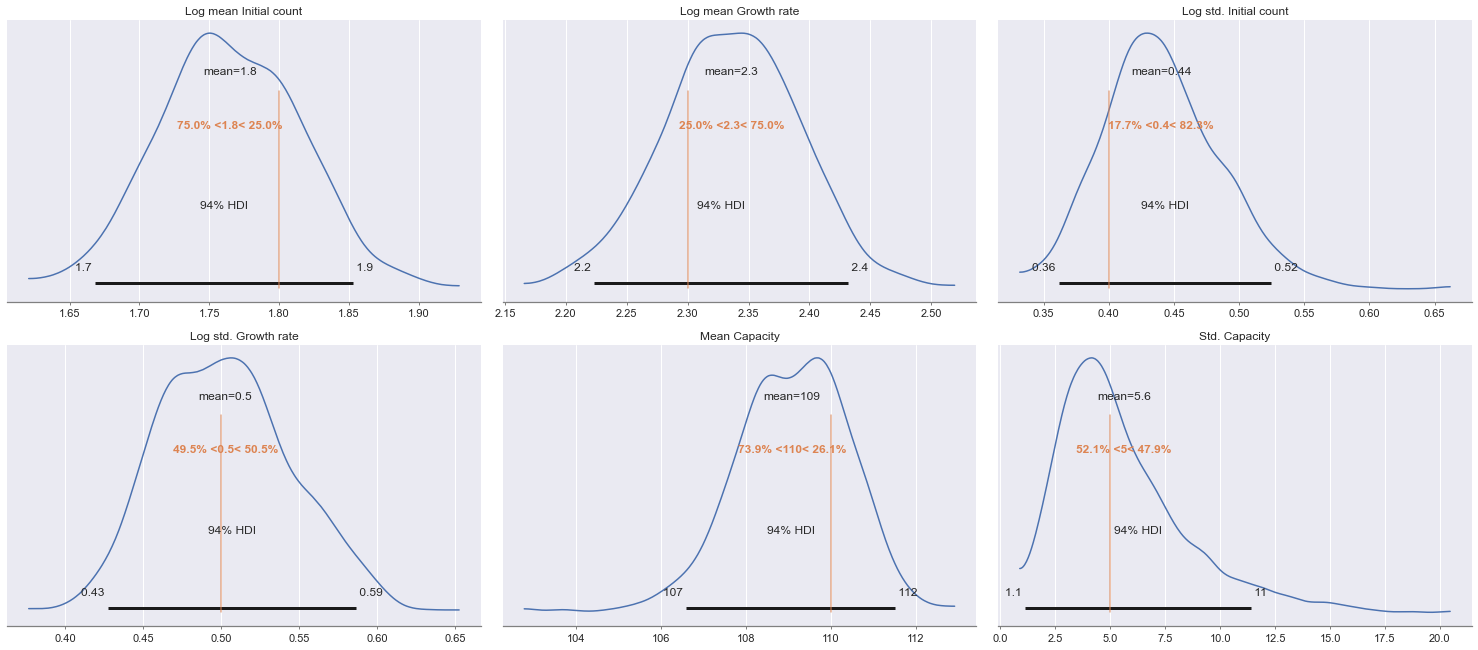

In [39]:
warmup = 500
thinning = 1
az.plot_posterior(
    posterior_samples_filter.sel(draw=slice(warmup, n_iterations, thinning)),
    var_names=[
        'Log mean Initial count',
        'Log mean Growth rate',
        'Log std. Initial count',
        'Log std. Growth rate',
        'Mean Capacity',
        'Std. Capacity'],
    ref_val=population_parameters[:-1])
plt.tight_layout()

### Results

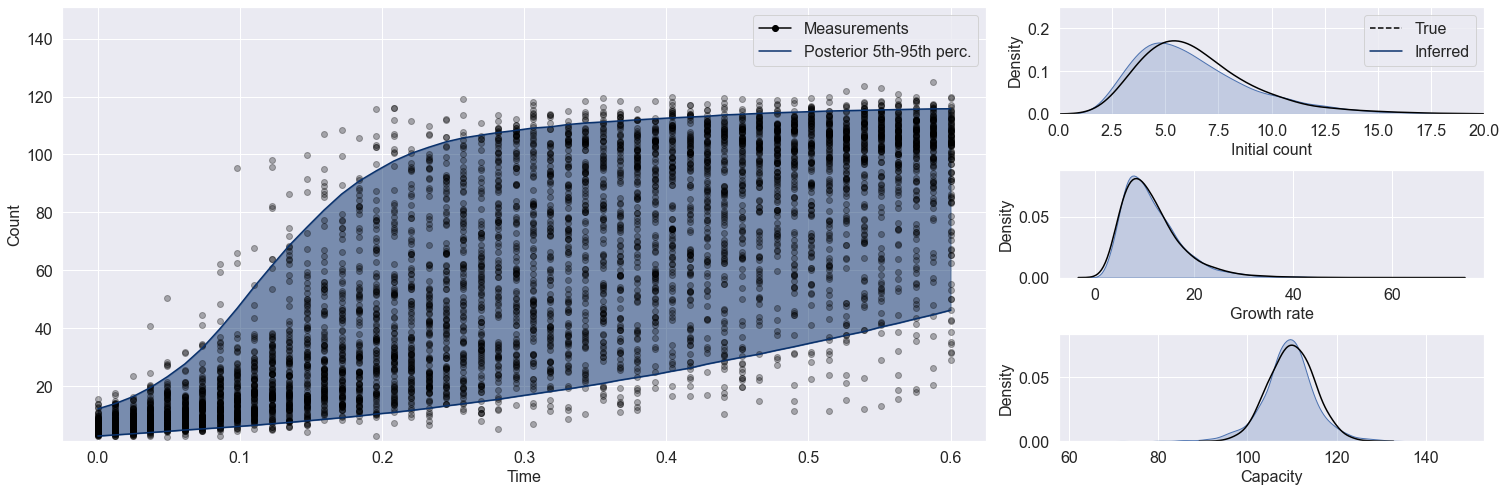

In [40]:
# Set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(1, 3, (1, 2))
ax2 = fig.add_subplot(3, 3, 3)
ax3 = fig.add_subplot(3, 3, 6)
ax4 = fig.add_subplot(3, 3, 9)
axes = [ax2, ax3, ax4]

# Define population model (central parametrisation)
population_model = chi.ComposedPopulationModel([
    chi.LogNormalModel(n_dim=2, dim_names=['Initial count', 'Growth rate']),
    chi.GaussianModel(dim_names=['Capacity'])])

# Plot population filter inference results (parameter space)
seed = np.random.default_rng(3)
n_samples = 5000
parameters =  posterior_samples_filter.sel(draw=slice(warmup, n_iterations))
parameters = np.vstack([
    parameters['Log mean Initial count'].values.flatten(),
    parameters['Log mean Growth rate'].values.flatten(),
    parameters['Log std. Initial count'].values.flatten(),
    parameters['Log std. Growth rate'].values.flatten(),
    parameters['Mean Capacity'].values.flatten(),
    parameters['Std. Capacity'].values.flatten()]).T
parameters = parameters[
    np.random.choice(np.arange(len(parameters)), size=n_samples, replace=True)]
samples = np.empty(shape=(n_samples, 3))
for ids, params in enumerate(parameters):
    samples[ids, :] = population_model.sample(params, seed=seed)[0]
for idp, _ in enumerate(['Initial count', 'Growth rate', 'Capacity']):
    sns.kdeplot(
        x=samples[:, idp], fill=True, bw_adjust=1, ax=axes[idp])

# Plot population filter inference results (measurement space)
times = np.linspace(0, 0.6)
n_times = len(times)
predictive_model = chi.PredictiveModel(mechanistic_model, error_model)
simulated_measurements = np.empty(shape=(n_samples, n_times))
parameters = np.empty(shape=(n_samples, 4))
parameters[:, :3] = samples
parameters[:, 3] = population_parameters[-1]
for ids, sample in enumerate(parameters):
    simulated_measurements[ids, :] = predictive_model.sample(
        parameters=sample, times=times, seed=seed, return_df=False)[0, :, 0]
fifth_percentile = np.percentile(simulated_measurements, q=5, axis=0)
ninetyfifth_percentile = np.percentile(simulated_measurements, q=95, axis=0)
ax1.plot(
    times, fifth_percentile, color=plt.get_cmap('Blues_r')(0))
ax1.plot(
    times, ninetyfifth_percentile, color=plt.get_cmap('Blues_r')(0))
ax1.fill_between(
    times, fifth_percentile, ninetyfifth_percentile,
    color=plt.get_cmap('Blues_r')(0), alpha=0.5)

# Plot data-generating distribution as reference to parameter space
samples = population_model.sample(population_parameters[:-1], n_samples, seed)
for idp, _ in enumerate(['Initial count', 'Growth rate', 'Capacity']):
    sns.kdeplot(
        x=samples[:, idp], fill=False, bw_adjust=1.5, color='black',
        ax=axes[idp])

# Plot measurement used for the inference as reference
for idm, meas in enumerate(measurements):
    ax1.scatter(
        times, meas[0], color='black', marker='o', alpha=0.3)

# Legend, ranges axes labels
fontsize = 16
ax1.set_xlabel('Time', fontsize=fontsize)
ax1.set_ylabel('Count', fontsize=fontsize)
ax1.tick_params(labelsize=fontsize)
ax1.plot(
    [1000, 1001], [1000, 1001], color='black', linestyle='solid', marker='o',
    label='Measurements')
ax1.plot(
    [1000, 1001], [1000, 1001], color=plt.get_cmap('Blues_r')(0),
    linestyle='solid', label='Posterior 5th-95th perc.')
ax1.set_xlim([-0.025, 0.625])
ax1.set_ylim([1, 151])
ax2.plot(
    [100, 101], [100, 101], color='black', linestyle='--', label='True')
ax2.plot(
    [100, 101], [100, 101], color=plt.get_cmap('Blues_r')(0),label='Inferred')
ax2.set_xlim([0, 20])
ax2.set_ylim([0, 0.25])
ax2.set_xlabel('Initial count', fontsize=fontsize)
ax2.set_ylabel('Density', fontsize=fontsize)
ax2.tick_params(labelsize=fontsize)
ax3.set_xlabel('Growth rate', fontsize=fontsize)
ax3.set_ylabel('Density', fontsize=fontsize)
ax3.tick_params(labelsize=fontsize)
ax4.set_xlabel('Capacity', fontsize=fontsize)
ax4.set_ylabel('Density', fontsize=fontsize)
ax4.tick_params(labelsize=fontsize)
ax1.legend(fontsize=fontsize)
ax2.legend(fontsize=fontsize)
plt.tight_layout()
plt.show()

### Gaussian KDE filter

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     4      0.25     1        0:00.1
1     5      0.25     1        0:00.1
2     6      0.25     1        0:00.1
3     7      0.25     1        0:00.1
20    11237  0.722    624      4:21.6
40    26114  0.732    709     10:11.1
60    41966  0.787    755     16:19.6
80    56145  0.743    676     21:46.9
100   70090  0.715928 664     27:09.1
120   73337  0.728    155     28:24.2
140   75941  0.757    124     29:24.6
160   77916  0.724369 94      30:10.0
180   80616  0.736    129     31:12.1
200   82612  0.772    96      31:58.9
220   85088  0.751    118     32:56.6
240   87180  0.744    100     33:44.4
260   89123  0.732    93      34:28.5
280   91439  0.751    111     35:23.5
300   93883  0.773    117     36:19.8
320   96135  0.739    108     37:12.7
340   98291  0.756    103     38:01.8
360   100095  0.748    86      38:43.4
380   101803  0.784    82      39:23.0
400   103767  0.

/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/arviz/plots/traceplot.py:210: UserWarning:

rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (59), generating only 20 plots



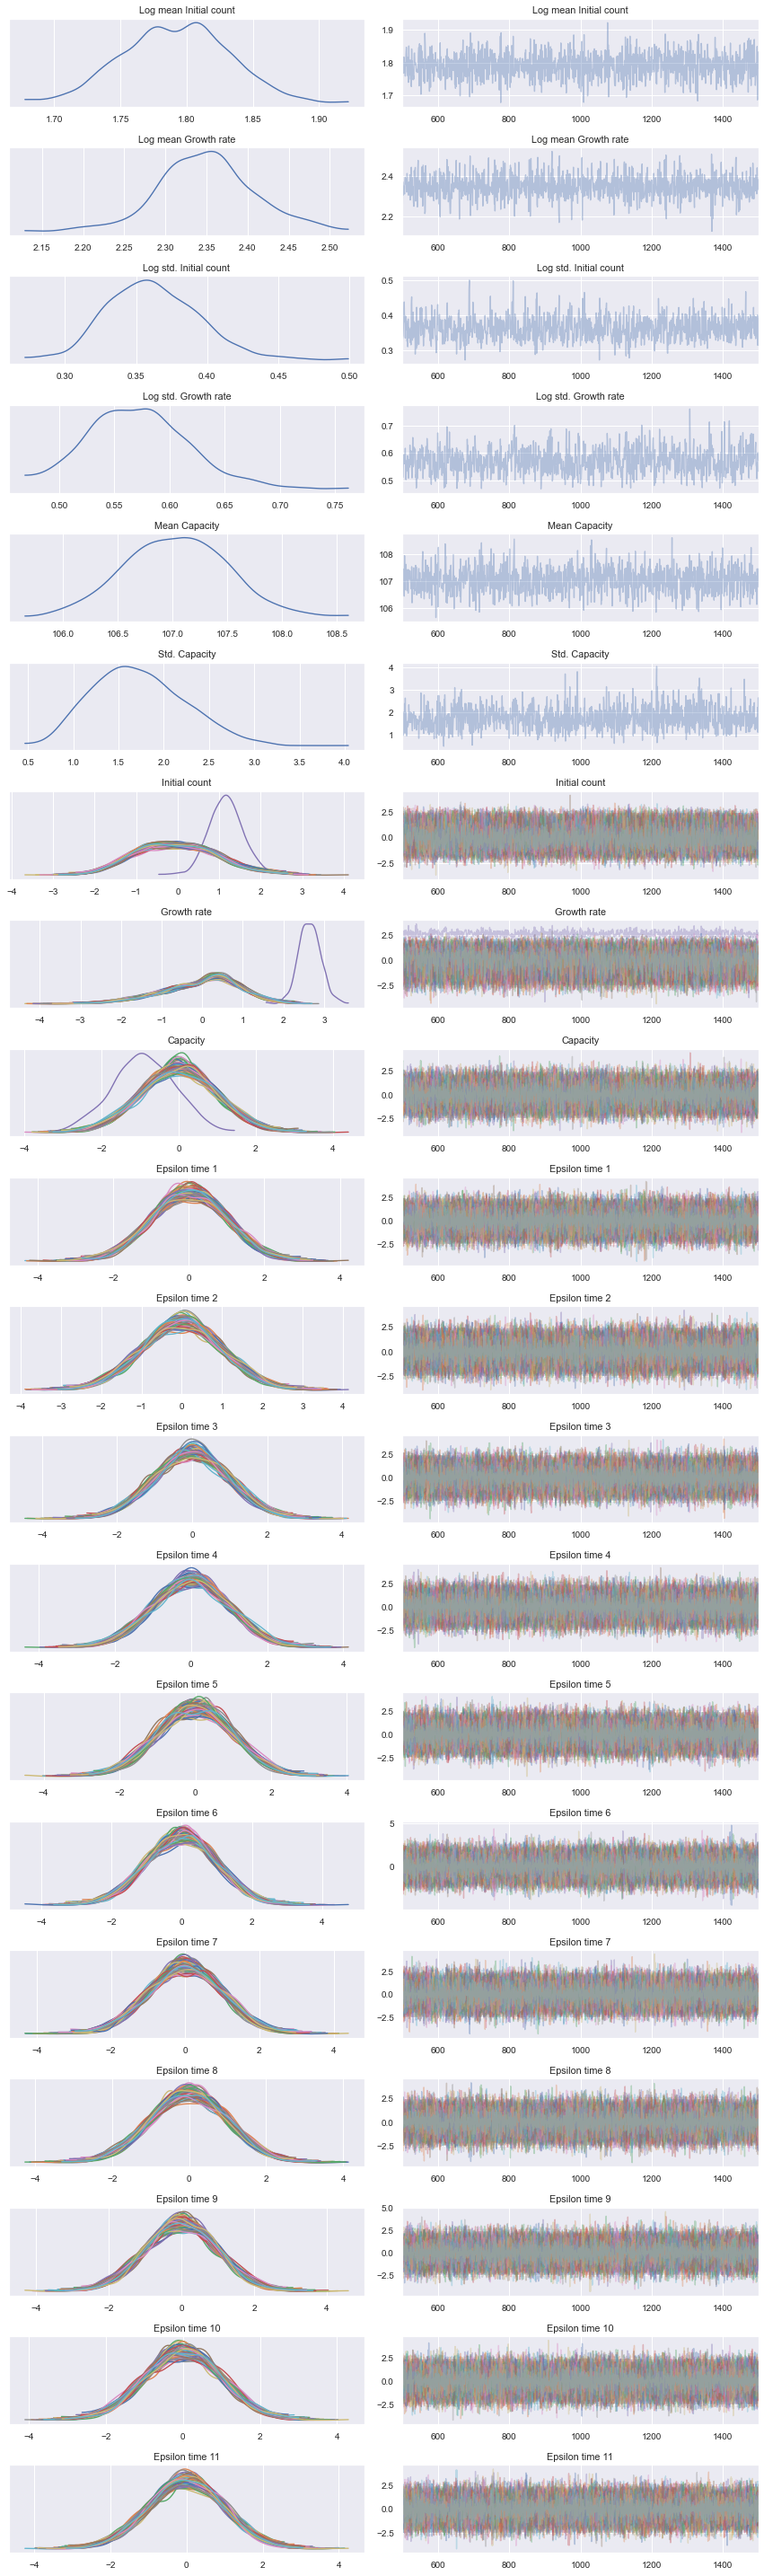

In [41]:
# Define population filter log-posterior
population_filter = chi.GaussianKDEFilter(measurements)
population_model = chi.ComposedPopulationModel([
    chi.LogNormalModel(
        n_dim=2, dim_names=['Initial count', 'Growth rate'], centered=False),
    chi.GaussianModel(dim_names=['Capacity'], centered=False)])
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(1, 3),        # Log mean initial condition
    pints.GaussianLogPrior(3, 3),        # Log mean exponential growth
    pints.LogNormalLogPrior(-0.1, 0.5),  # Log std. initial condition
    pints.LogNormalLogPrior(-0.1, 0.5),  # Log std. exponential growth
    pints.GaussianLogPrior(100, 10),     # Mean capacity
    pints.LogNormalLogPrior(1.5, 0.5))   # Std. capacity
log_posterior = chi.PopulationFilterLogPosterior(
    population_filter, times, mechanistic_model, population_model, log_prior,
    sigma=population_parameters[-1])

# Run inference
seed = 2
controller = chi.SamplingController(log_posterior, seed=seed)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
posterior_samples_filter = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning = 1
az.plot_trace(
    posterior_samples_filter.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

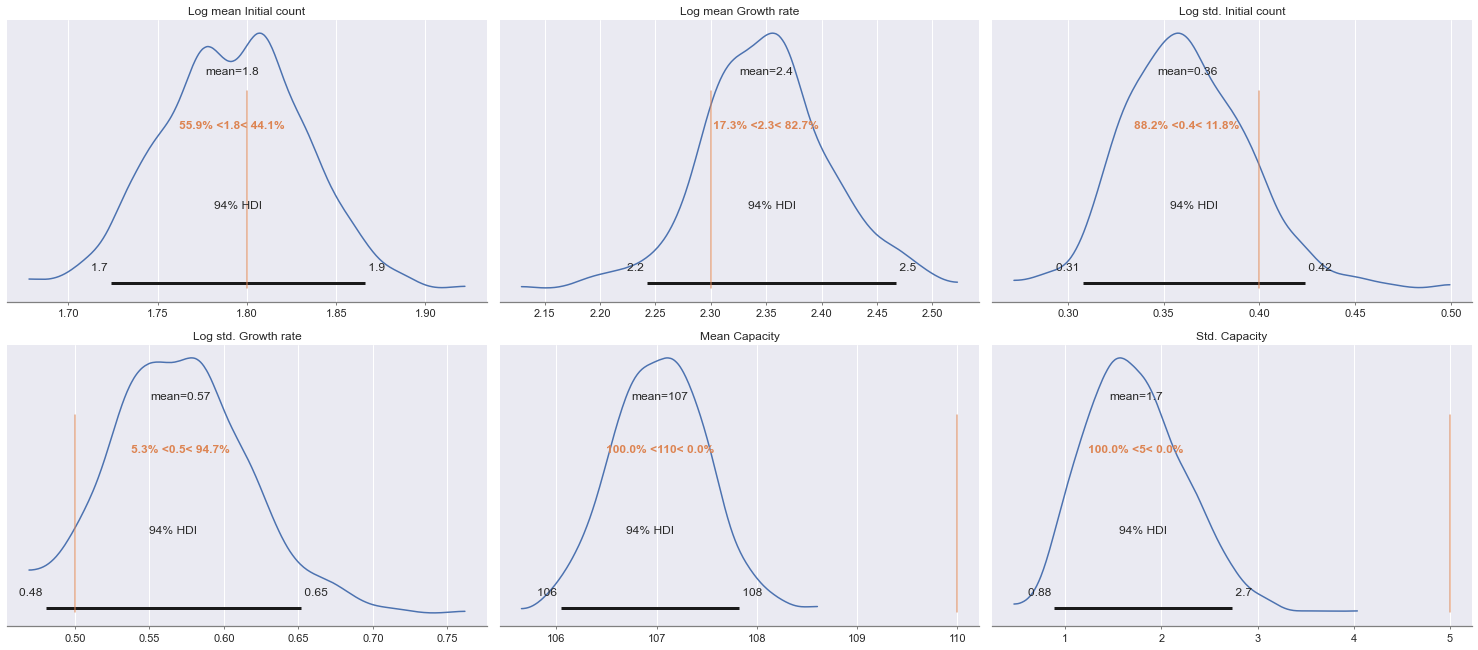

In [42]:
warmup = 500
thinning = 1
az.plot_posterior(
    posterior_samples_filter.sel(draw=slice(warmup, n_iterations, thinning)),
    var_names=[
        'Log mean Initial count',
        'Log mean Growth rate',
        'Log std. Initial count',
        'Log std. Growth rate',
        'Mean Capacity',
        'Std. Capacity'],
    ref_val=population_parameters[:-1])
plt.tight_layout()

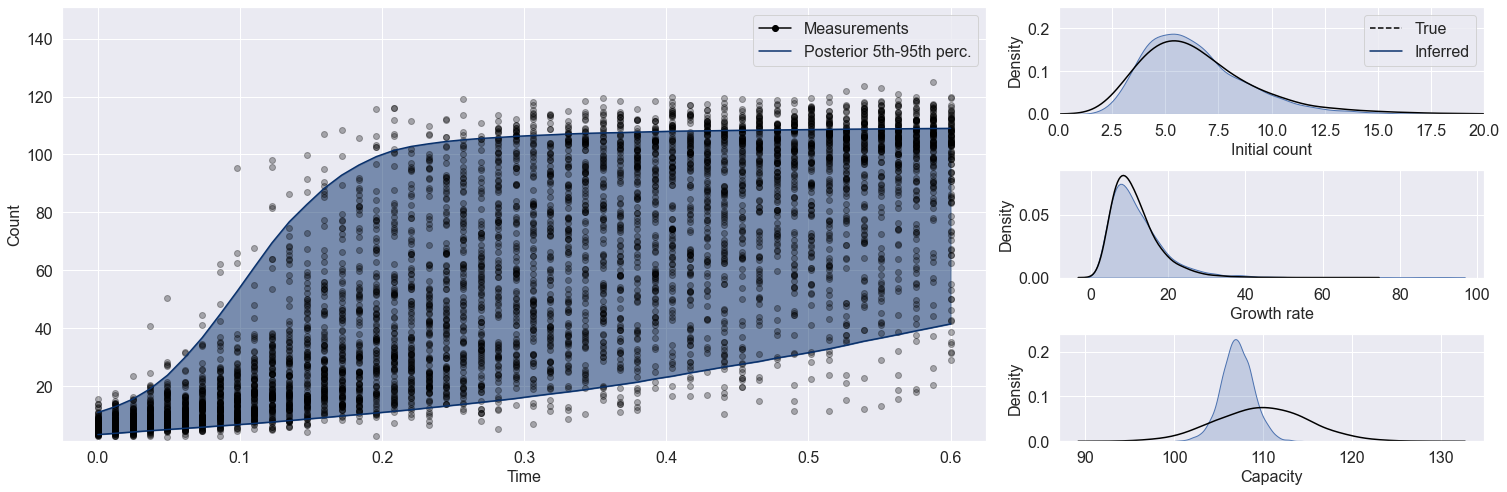

In [43]:
# Set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(1, 3, (1, 2))
ax2 = fig.add_subplot(3, 3, 3)
ax3 = fig.add_subplot(3, 3, 6)
ax4 = fig.add_subplot(3, 3, 9)
axes = [ax2, ax3, ax4]

# Define population model (central parametrisation)
population_model = chi.ComposedPopulationModel([
    chi.LogNormalModel(n_dim=2, dim_names=['Initial count', 'Growth rate']),
    chi.GaussianModel(dim_names=['Capacity'])])

# Plot population filter inference results (parameter space)
seed = np.random.default_rng(3)
n_samples = 5000
parameters =  posterior_samples_filter.sel(draw=slice(warmup, n_iterations))
parameters = np.vstack([
    parameters['Log mean Initial count'].values.flatten(),
    parameters['Log mean Growth rate'].values.flatten(),
    parameters['Log std. Initial count'].values.flatten(),
    parameters['Log std. Growth rate'].values.flatten(),
    parameters['Mean Capacity'].values.flatten(),
    parameters['Std. Capacity'].values.flatten()]).T
parameters = parameters[
    np.random.choice(np.arange(len(parameters)), size=n_samples, replace=True)]
samples = np.empty(shape=(n_samples, 3))
for ids, params in enumerate(parameters):
    samples[ids, :] = population_model.sample(params, seed=seed)[0]
for idp, _ in enumerate(['Initial count', 'Growth rate', 'Capacity']):
    sns.kdeplot(
        x=samples[:, idp], fill=True, bw_adjust=1, ax=axes[idp])

# Plot population filter inference results (measurement space)
times = np.linspace(0, 0.6)
n_times = len(times)
predictive_model = chi.PredictiveModel(mechanistic_model, error_model)
simulated_measurements = np.empty(shape=(n_samples, n_times))
parameters = np.empty(shape=(n_samples, 4))
parameters[:, :3] = samples
parameters[:, 3] = population_parameters[-1]
for ids, sample in enumerate(parameters):
    simulated_measurements[ids, :] = predictive_model.sample(
        parameters=sample, times=times, seed=seed, return_df=False)[0, :, 0]
fifth_percentile = np.percentile(simulated_measurements, q=5, axis=0)
ninetyfifth_percentile = np.percentile(simulated_measurements, q=95, axis=0)
ax1.plot(
    times, fifth_percentile, color=plt.get_cmap('Blues_r')(0))
ax1.plot(
    times, ninetyfifth_percentile, color=plt.get_cmap('Blues_r')(0))
ax1.fill_between(
    times, fifth_percentile, ninetyfifth_percentile,
    color=plt.get_cmap('Blues_r')(0), alpha=0.5)

# Plot data-generating distribution as reference to parameter space
samples = population_model.sample(population_parameters[:-1], n_samples, seed)
for idp, _ in enumerate(['Initial count', 'Growth rate', 'Capacity']):
    sns.kdeplot(
        x=samples[:, idp], fill=False, bw_adjust=1.5, color='black',
        ax=axes[idp])

# Plot measurement used for the inference as reference
for idm, meas in enumerate(measurements):
    ax1.scatter(
        times, meas[0], color='black', marker='o', alpha=0.3)

# Legend, ranges axes labels
fontsize = 16
ax1.set_xlabel('Time', fontsize=fontsize)
ax1.set_ylabel('Count', fontsize=fontsize)
ax1.tick_params(labelsize=fontsize)
ax1.plot(
    [1000, 1001], [1000, 1001], color='black', linestyle='solid', marker='o',
    label='Measurements')
ax1.plot(
    [1000, 1001], [1000, 1001], color=plt.get_cmap('Blues_r')(0),
    linestyle='solid', label='Posterior 5th-95th perc.')
ax1.set_xlim([-0.025, 0.625])
ax1.set_ylim([1, 151])
ax2.plot(
    [100, 101], [100, 101], color='black', linestyle='--', label='True')
ax2.plot(
    [100, 101], [100, 101], color=plt.get_cmap('Blues_r')(0),label='Inferred')
ax2.set_xlim([0, 20])
ax2.set_ylim([0, 0.25])
ax2.set_xlabel('Initial count', fontsize=fontsize)
ax2.set_ylabel('Density', fontsize=fontsize)
ax2.tick_params(labelsize=fontsize)
ax3.set_xlabel('Growth rate', fontsize=fontsize)
ax3.set_ylabel('Density', fontsize=fontsize)
ax3.tick_params(labelsize=fontsize)
ax4.set_xlabel('Capacity', fontsize=fontsize)
ax4.set_ylabel('Density', fontsize=fontsize)
ax4.tick_params(labelsize=fontsize)
ax1.legend(fontsize=fontsize)
ax2.legend(fontsize=fontsize)
plt.tight_layout()
plt.show()

### Lognormal KDE filter

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     6      0.333    1        0:00.1
1     7      0.25     1        0:00.1
2     8      0.25     1        0:00.2


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/chi/_population_filters.py:791: RuntimeWarning:

invalid value encountered in log

/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning:

overflow encountered in exp

/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning:

overflow encountered in exp



3     16     0.389    4        0:00.9
20    11844  0.754    658      4:36.6
40    24785  0.73413  617      9:30.6
60    37891  0.772    625     14:31.6
80    50253  0.756    589     19:15.6
100   63893  0.768    650     24:28.6
120   66536  0.73     126     25:29.8
140   68436  0.732    91      26:14.0
160   70219  0.744    85      26:55.6
180   71959  0.743    83      27:36.0
200   73987  0.775    97      28:23.0
220   75375  0.763    67      28:55.5
240   76635  0.769    60      29:24.9
260   77970  0.689    64      29:56.2
280   79950  0.774    95      30:42.2
300   81882  0.754    92      31:27.2
320   83398  0.767    73      32:02.4
340   85138  0.73     83      32:42.9
360   86558  0.773    68      33:16.1
380   87946  0.774    67      33:49.0
400   89302  0.73     65      34:24.2
420   90498  0.757    57      34:53.8
440   91854  0.768    65      35:27.3
460   93316  0.739    70      36:03.0
480   94576  0.768    60      36:32.8
500   96028  0.731561 70      37:10.3
520   97288 

/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/arviz/plots/traceplot.py:210: UserWarning:

rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (59), generating only 20 plots



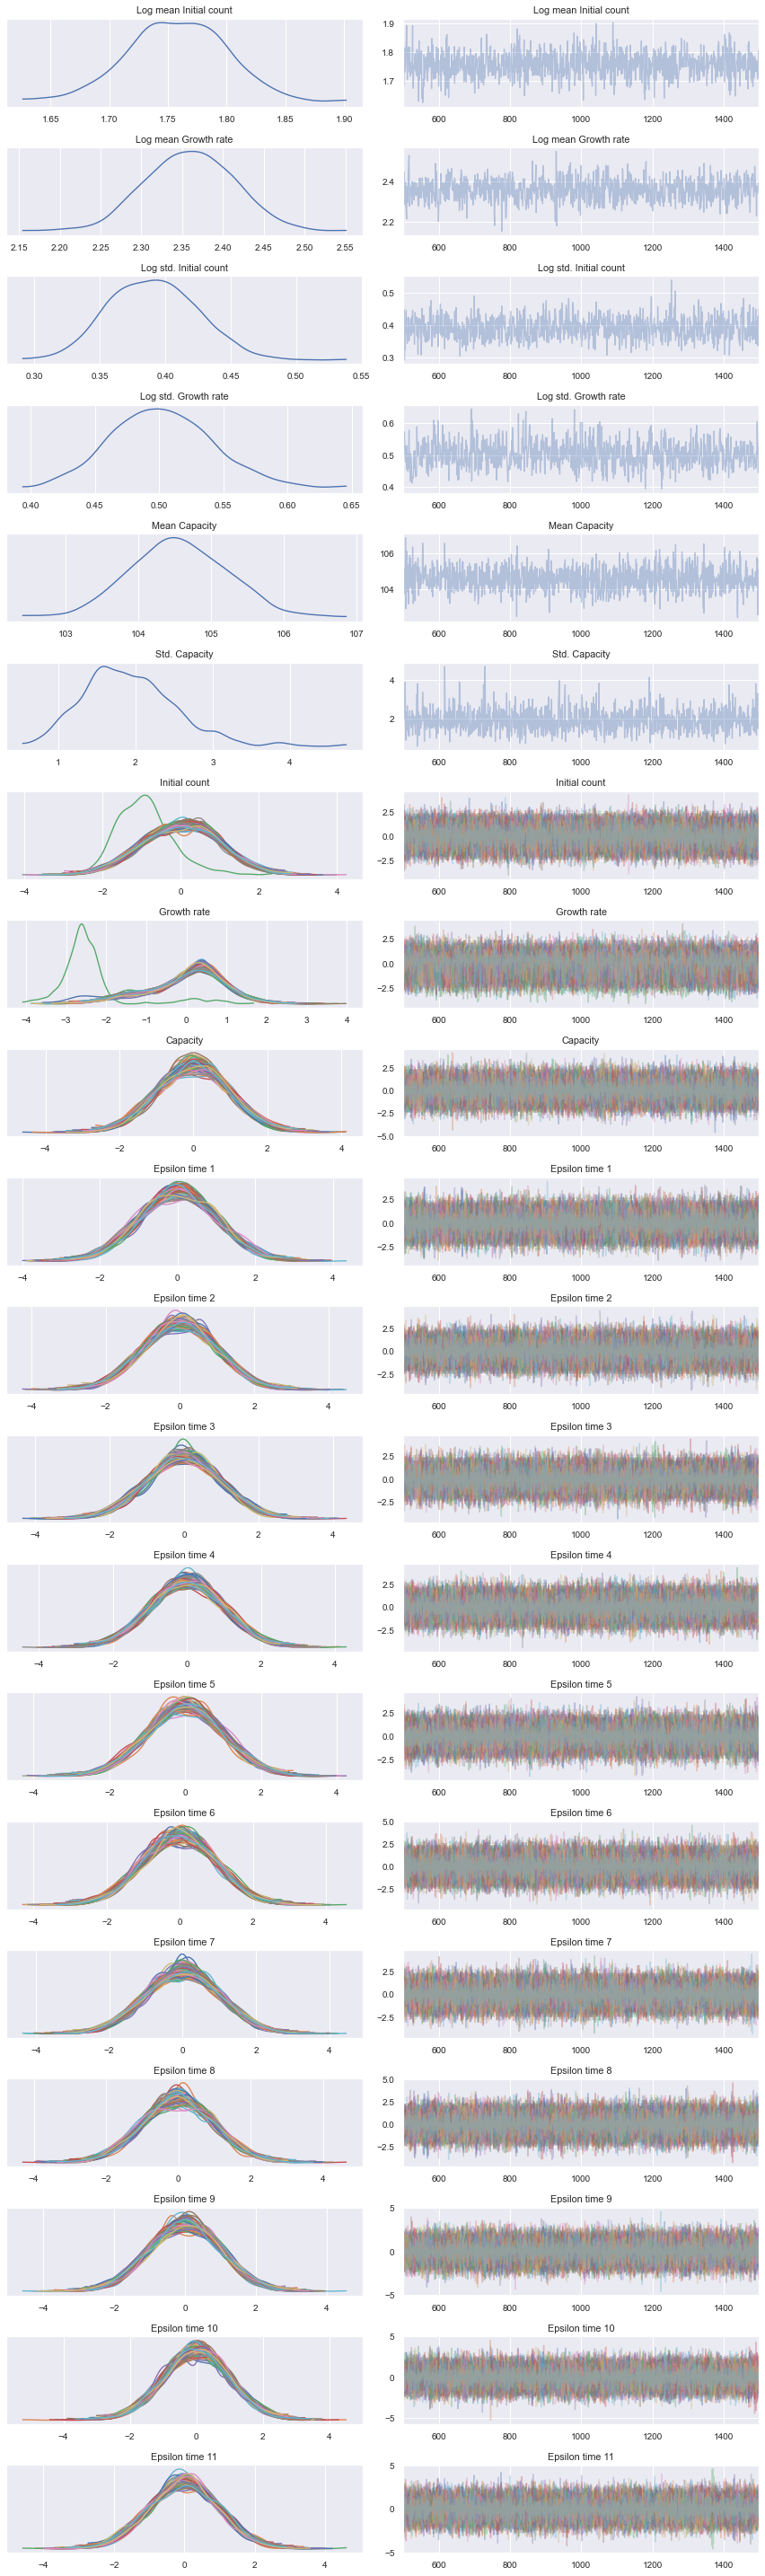

In [44]:
# Define population filter log-posterior
population_filter = chi.LogNormalKDEFilter(measurements)
population_model = chi.ComposedPopulationModel([
    chi.LogNormalModel(
        n_dim=2, dim_names=['Initial count', 'Growth rate'], centered=False),
    chi.GaussianModel(dim_names=['Capacity'], centered=False)])
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(1, 3),        # Log mean initial condition
    pints.GaussianLogPrior(3, 3),        # Log mean exponential growth
    pints.LogNormalLogPrior(-0.1, 0.5),  # Log std. initial condition
    pints.LogNormalLogPrior(-0.1, 0.5),  # Log std. exponential growth
    pints.GaussianLogPrior(100, 10),     # Mean capacity
    pints.LogNormalLogPrior(1.5, 0.5))   # Std. capacity
log_posterior = chi.PopulationFilterLogPosterior(
    population_filter, times, mechanistic_model, population_model, log_prior,
    sigma=population_parameters[-1])

# Run inference
seed = 2
controller = chi.SamplingController(log_posterior, seed=seed)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
posterior_samples_filter = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning = 1
az.plot_trace(
    posterior_samples_filter.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

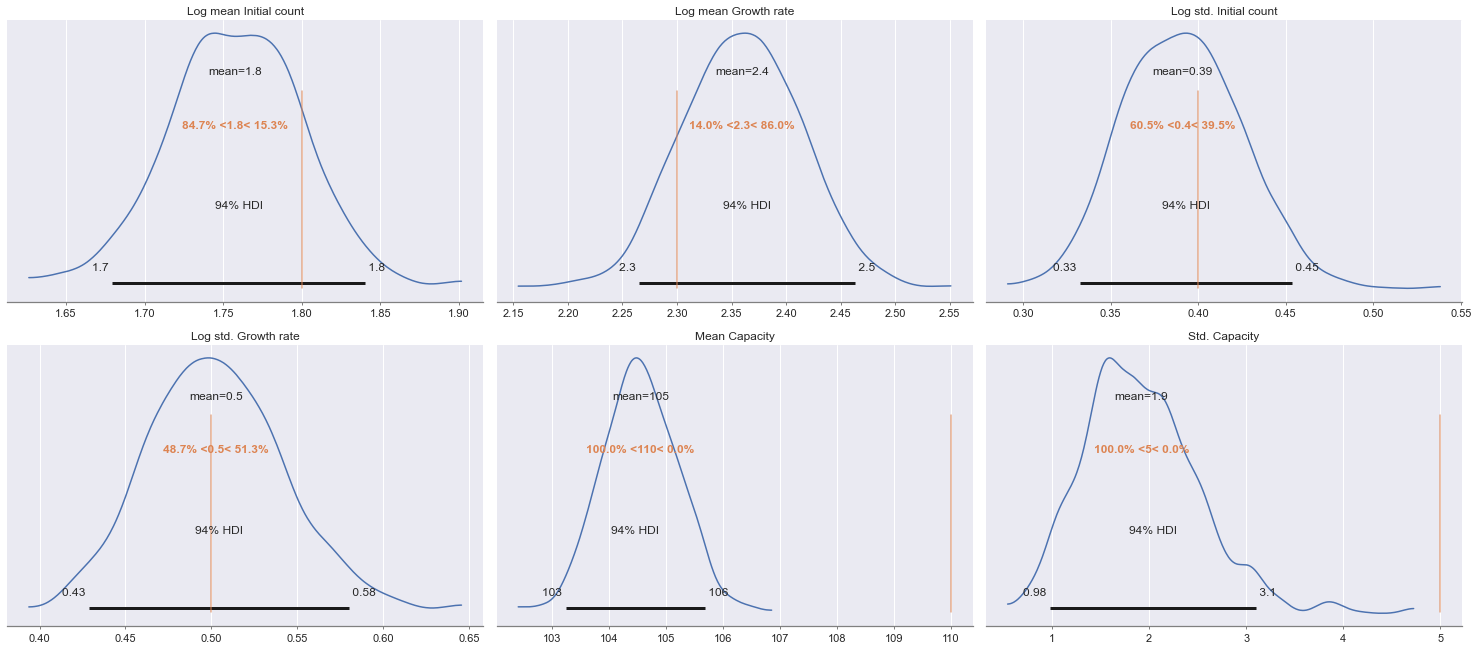

In [45]:
warmup = 500
thinning = 1
az.plot_posterior(
    posterior_samples_filter.sel(draw=slice(warmup, n_iterations, thinning)),
    var_names=[
        'Log mean Initial count',
        'Log mean Growth rate',
        'Log std. Initial count',
        'Log std. Growth rate',
        'Mean Capacity',
        'Std. Capacity'],
    ref_val=population_parameters[:-1])
plt.tight_layout()

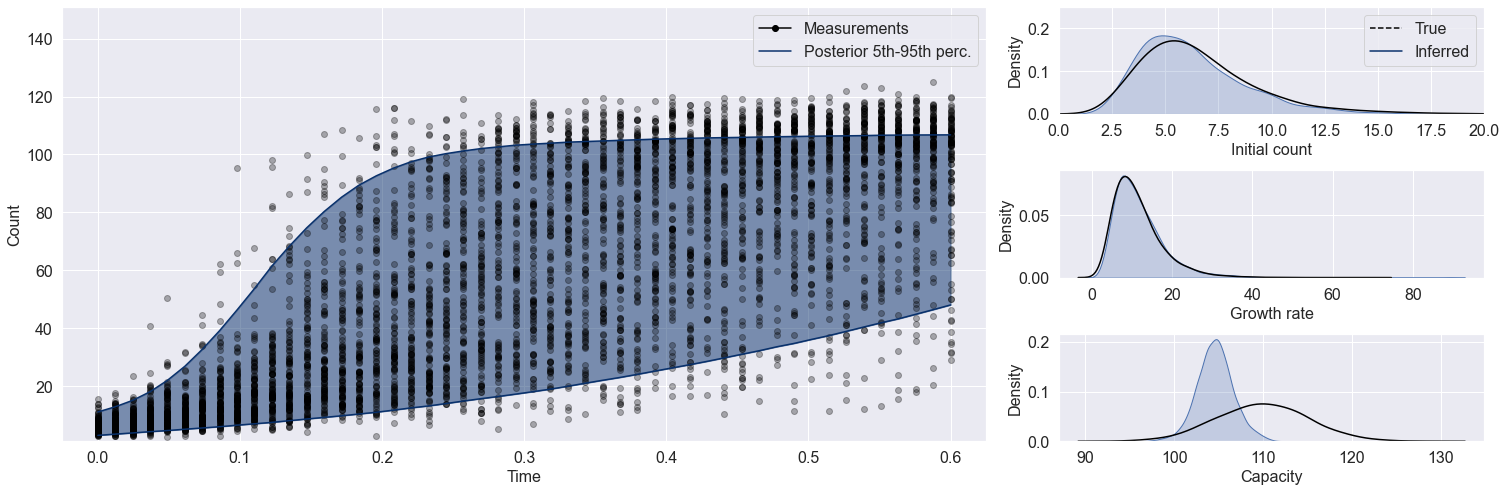

In [46]:
# Set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(1, 3, (1, 2))
ax2 = fig.add_subplot(3, 3, 3)
ax3 = fig.add_subplot(3, 3, 6)
ax4 = fig.add_subplot(3, 3, 9)
axes = [ax2, ax3, ax4]

# Define population model (central parametrisation)
population_model = chi.ComposedPopulationModel([
    chi.LogNormalModel(n_dim=2, dim_names=['Initial count', 'Growth rate']),
    chi.GaussianModel(dim_names=['Capacity'])])

# Plot population filter inference results (parameter space)
seed = np.random.default_rng(3)
n_samples = 5000
parameters =  posterior_samples_filter.sel(draw=slice(warmup, n_iterations))
parameters = np.vstack([
    parameters['Log mean Initial count'].values.flatten(),
    parameters['Log mean Growth rate'].values.flatten(),
    parameters['Log std. Initial count'].values.flatten(),
    parameters['Log std. Growth rate'].values.flatten(),
    parameters['Mean Capacity'].values.flatten(),
    parameters['Std. Capacity'].values.flatten()]).T
parameters = parameters[
    np.random.choice(np.arange(len(parameters)), size=n_samples, replace=True)]
samples = np.empty(shape=(n_samples, 3))
for ids, params in enumerate(parameters):
    samples[ids, :] = population_model.sample(params, seed=seed)[0]
for idp, _ in enumerate(['Initial count', 'Growth rate', 'Capacity']):
    sns.kdeplot(
        x=samples[:, idp], fill=True, bw_adjust=1, ax=axes[idp])

# Plot population filter inference results (measurement space)
times = np.linspace(0, 0.6)
n_times = len(times)
predictive_model = chi.PredictiveModel(mechanistic_model, error_model)
simulated_measurements = np.empty(shape=(n_samples, n_times))
parameters = np.empty(shape=(n_samples, 4))
parameters[:, :3] = samples
parameters[:, 3] = population_parameters[-1]
for ids, sample in enumerate(parameters):
    simulated_measurements[ids, :] = predictive_model.sample(
        parameters=sample, times=times, seed=seed, return_df=False)[0, :, 0]
fifth_percentile = np.percentile(simulated_measurements, q=5, axis=0)
ninetyfifth_percentile = np.percentile(simulated_measurements, q=95, axis=0)
ax1.plot(
    times, fifth_percentile, color=plt.get_cmap('Blues_r')(0))
ax1.plot(
    times, ninetyfifth_percentile, color=plt.get_cmap('Blues_r')(0))
ax1.fill_between(
    times, fifth_percentile, ninetyfifth_percentile,
    color=plt.get_cmap('Blues_r')(0), alpha=0.5)

# Plot data-generating distribution as reference to parameter space
samples = population_model.sample(population_parameters[:-1], n_samples, seed)
for idp, _ in enumerate(['Initial count', 'Growth rate', 'Capacity']):
    sns.kdeplot(
        x=samples[:, idp], fill=False, bw_adjust=1.5, color='black',
        ax=axes[idp])

# Plot measurement used for the inference as reference
for idm, meas in enumerate(measurements):
    ax1.scatter(
        times, meas[0], color='black', marker='o', alpha=0.3)

# Legend, ranges axes labels
fontsize = 16
ax1.set_xlabel('Time', fontsize=fontsize)
ax1.set_ylabel('Count', fontsize=fontsize)
ax1.tick_params(labelsize=fontsize)
ax1.plot(
    [1000, 1001], [1000, 1001], color='black', linestyle='solid', marker='o',
    label='Measurements')
ax1.plot(
    [1000, 1001], [1000, 1001], color=plt.get_cmap('Blues_r')(0),
    linestyle='solid', label='Posterior 5th-95th perc.')
ax1.set_xlim([-0.025, 0.625])
ax1.set_ylim([1, 151])
ax2.plot(
    [100, 101], [100, 101], color='black', linestyle='--', label='True')
ax2.plot(
    [100, 101], [100, 101], color=plt.get_cmap('Blues_r')(0),label='Inferred')
ax2.set_xlim([0, 20])
ax2.set_ylim([0, 0.25])
ax2.set_xlabel('Initial count', fontsize=fontsize)
ax2.set_ylabel('Density', fontsize=fontsize)
ax2.tick_params(labelsize=fontsize)
ax3.set_xlabel('Growth rate', fontsize=fontsize)
ax3.set_ylabel('Density', fontsize=fontsize)
ax3.tick_params(labelsize=fontsize)
ax4.set_xlabel('Capacity', fontsize=fontsize)
ax4.set_ylabel('Density', fontsize=fontsize)
ax4.tick_params(labelsize=fontsize)
ax1.legend(fontsize=fontsize)
ax2.legend(fontsize=fontsize)
plt.tight_layout()
plt.show()